# Pneumonia Detection Bot
Created by Jamil Abbas   
Last Updated: 2021-05-03 

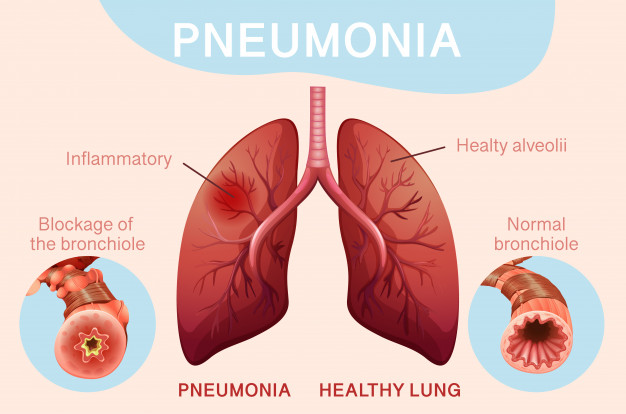 $^1$

Pneumonia is an infected that targets air sacs within the lungs which causes inflamation and possibly cause them to fill with fluid or pus. Pneumonia can range in seriousness depending on the type of person that is infected with it but typically infants, young children, people over the age of 65, people with health problems or weakened immune systems are the most at risk. It is labeled as a very common disease with more than 3 million cases in the United States per year and is spread through airborne respiratory droplets (such as coughs or sneezes). $^2$

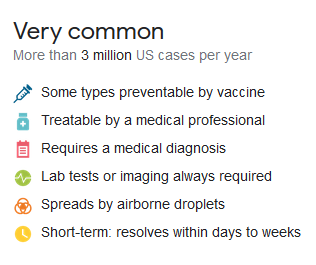

Taking a look at some of the attributes associated with pneumonia, one of them includes "Lab tests of imaging always required". What is meant by this is that in order to diagnose someone with pneumonia they either have to conduct lab tests or in the case of imaging, have an x-ray of their chest done and assign the image to a radiologist and have them diagnose you. 
This project aims to tackle the issue of pneumonia diagnosis through imaging for the purpose of presenting an idea to help advance pneumonia dignosis in the future and hopefully conduct diagnosis in a more efficent manner. Given that the disease can be life threatening to certain populations, efficency in diagnosis could be crucial in saving someones life or preventing them from suffering severe health issues due to the infection. 

The process of diganosing pneumonia through an x-ray is done by examination by a radiologist. Due to the fact that chest x-rays that contain pneumonia are all subject to similar patterns based on the image, it should be possible for us to create a model to have a computer conduct this diagnosis for us. A computer is able to identify much smaller patterns in images that the human eye is able to do, and this is excluding the fact that a computer can recognize images at a more efficent rate than a human can. These reasons motivate us to attempt to create a model that is able to diagnose if a person has pneumonia based on an image of an x-ray of their chest. 

The project does this by creating a convolutional neural network (CNN) to break down the x-ray images in an attempt to identify patterns and then use logic to piece the patters back together and ultimately conclude whether this x-ray image is of a person that has penumonia or not. The model is created in Python's TensorFlow/Keras package.

The dataset utilzed is from: "Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification" by contributors Daniel Kermany, Kang Zhang, and Michael Goldbaum. $^3$ 

In [ ]:
####################
# REQUIRED MODULES #
####################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing import image_dataset_from_directory

from sklearn.metrics import confusion_matrix, plot_confusion_matrix

import os
import shutil
import random

import warnings 
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline 

## Import and Visualize the Data

In [3]:
#Create train, test, and validation folders from the total dataset

#Change this string to local absolute path to run on your personal machine
path = 'C:\Repositories\JamilAbbas\Pneumonia Detection\pneumonia_data'


os.chdir(path)
if os.path.isdir(os.path.join(path, 'train')) is False:
    os.makedirs('train/normal')
    os.makedirs('train/pneumonia')
    os.makedirs('valid/normal')
    os.makedirs('valid/pneumonia')
    os.makedirs('test/normal')
    os.makedirs('test/pneumonia')
    
    normal_files = os.listdir(os.path.join(path, 'normal'))
    pneumonia_files = os.listdir(os.path.join(path, 'pneumonia'))

    #Import random data points into training set (600 normal 1000 pneumonia)
    train_normal = random.sample(normal_files, 600)
    for f in train_normal:
        npath = os.path.join(path, 'normal', f)
        shutil.move(npath, 'train/normal')
        normal_files.remove(f)

    train_pneu = random.sample(pneumonia_files, 1000)
    for f in train_pneu:
        npath = os.path.join(path, 'pneumonia', f)
        shutil.move(npath, 'train/pneumonia')
        pneumonia_files.remove(f)


    #Import random data points into validation set (150 normal 250 pneumonia)
    valid_normal = random.sample(normal_files, 150)
    for f in valid_normal:
        npath = os.path.join(path, 'normal', f)
        shutil.move(npath, 'valid/normal')
        normal_files.remove(f)

    valid_pneu = random.sample(pneumonia_files, 250)
    for f in valid_pneu:
        npath = os.path.join(path, 'pneumonia', f)
        shutil.move(npath, 'valid/pneumonia')
        pneumonia_files.remove(f)

    #Import 150 random data points into testing set (100 normal 200 pneumonia)    
    test_normal = random.sample(normal_files, 100)
    for f in test_normal:
        npath = os.path.join(path, 'normal', f)
        shutil.move(npath, 'test/normal')
        normal_files.remove(f)

    test_pneu = random.sample(pneumonia_files, 200)
    for f in test_pneu:
        npath = os.path.join(path, 'pneumonia', f)
        shutil.move(npath, 'test/pneumonia')
        pneumonia_files.remove(f)


After importing the images into our notebook, the files are then converted into a tensorflow object so that they can be passed through our model later on. Note that in our test set of images
the labels are not imported as these will the be images that the model will be tested on after training. 

In [4]:
#import the data as a tensorflow dataset

#Create varaibles of the absolute filepath to each dataset folder
train_path = os.path.join(path, 'train')
val_path = os.path.join(path, 'valid')
test_path = os.path.join(path, 'test')

#Set batch size, and image height and weight 
batch_size = 16
img_height = 224
img_width = 224

#Create the training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    labels='inferred',
    label_mode = 'int',
    class_names = ['normal', 'pneumonia'],
    #color_mode = 'grayscale',
    image_size=(img_height, img_width),
    batch_size = batch_size
    )

#Create the validation dataset
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_path,
    labels='inferred',
    label_mode = 'int',
    class_names = ['normal', 'pneumonia'],
    #color_mode = 'grayscale',
    image_size=(img_height, img_width),
    batch_size = batch_size
    )

#Create the testing dataset
#NOTE: set 'shuffle = False' for the test dataset to preserve the label to image order for plotting a confusion matrix later on
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    label_mode=None,
    #color_mode = 'grayscale',
    image_size=(img_height, img_width),
    batch_size = batch_size, 
    shuffle=False
    )

Found 1600 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
Found 300 files belonging to 2 classes.


In [5]:
#Check the names of the classes of the imported images
class_names = train_ds.class_names
print(class_names)

['normal', 'pneumonia']


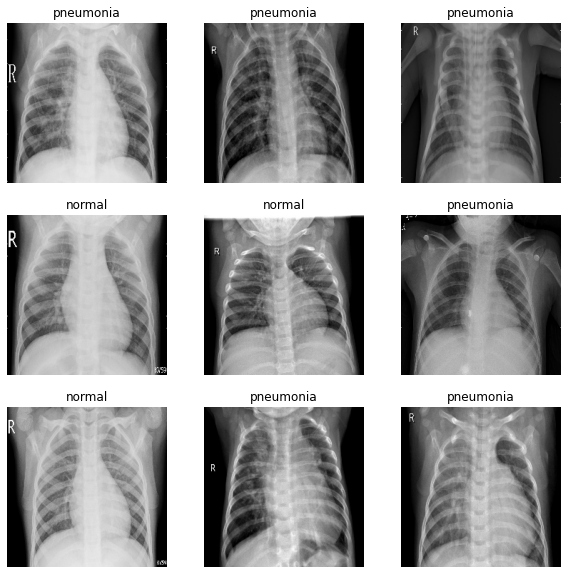

In [6]:
#Visualize first 9 training data images

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [7]:
#Print the batch_size and dimensions of the images for correct input
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(16, 224, 224, 3)
(16,)


## Convolutional Neural Network

The networks input layer consists of a preprocessing layer that scales the RGB channel values in the images between from their original range of [0, 255] to [0,1] so that the values are better fit for the model. Then there consists 3 pairs of convolutional and max pooling layers, followed by two dense layers, the last of which only has two outputs as the aim is to identify the image based on two classed [normal x-ray, pneumonia x-ray].  

In [8]:
#Create the model
num_classes = 2

model = Sequential([
    preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPooling2D(strides=2),
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPooling2D(strides=2),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPooling2D(strides=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')   
])

#Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0

In [9]:
#Compile the model
model.compile(optimizer=Adam(lr=0.001),
             loss=SparseCategoricalCrossentropy(),
             metrics=['accuracy'])

In [10]:
#Train the model 
epochs = 10

history = model.fit(train_ds,
                   validation_data=valid_ds,
                   epochs=epochs, 
                   verbose=2)

Epoch 1/10
100/100 - 56s - loss: 0.4784 - accuracy: 0.7719 - val_loss: 0.1815 - val_accuracy: 0.9225
Epoch 2/10
100/100 - 53s - loss: 0.1937 - accuracy: 0.9144 - val_loss: 0.1589 - val_accuracy: 0.9375
Epoch 3/10
100/100 - 53s - loss: 0.1603 - accuracy: 0.9444 - val_loss: 0.1510 - val_accuracy: 0.9475
Epoch 4/10
100/100 - 50s - loss: 0.1472 - accuracy: 0.9431 - val_loss: 0.1619 - val_accuracy: 0.9425
Epoch 5/10
100/100 - 53s - loss: 0.1396 - accuracy: 0.9375 - val_loss: 0.1230 - val_accuracy: 0.9525
Epoch 6/10
100/100 - 51s - loss: 0.0925 - accuracy: 0.9650 - val_loss: 0.1319 - val_accuracy: 0.9600
Epoch 7/10
100/100 - 52s - loss: 0.0712 - accuracy: 0.9756 - val_loss: 0.1764 - val_accuracy: 0.9450
Epoch 8/10
100/100 - 51s - loss: 0.0475 - accuracy: 0.9831 - val_loss: 0.1732 - val_accuracy: 0.9425
Epoch 9/10
100/100 - 52s - loss: 0.0353 - accuracy: 0.9881 - val_loss: 0.1746 - val_accuracy: 0.9400
Epoch 10/10
100/100 - 50s - loss: 0.0198 - accuracy: 0.9956 - val_loss: 0.1915 - val_accura

In [13]:
#Save the model
model.save('pneumonia_model.h5')

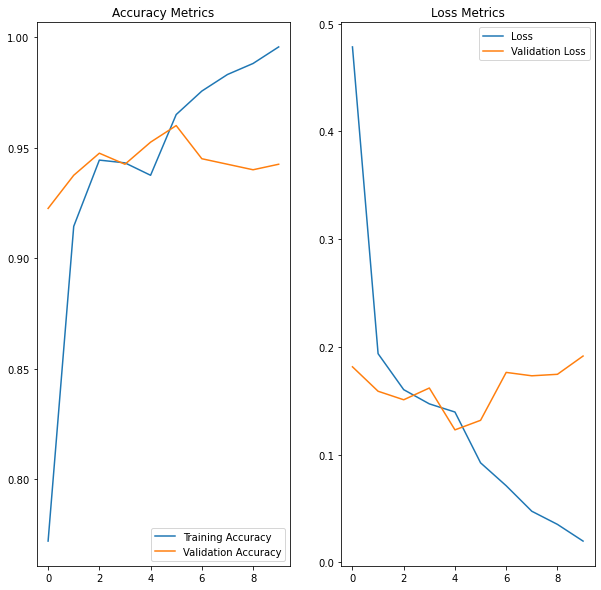

In [11]:
#visualize performance metrics

#Accuracy 
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

#Loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epoch_range = range(epochs)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(epoch_range, acc, label='Training Accuracy')
plt.plot(epoch_range, val_acc, label='Validation Accuracy')
plt.title('Accuracy Metrics')
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(epoch_range, loss, label='Loss')
plt.plot(epoch_range, val_loss, label='Validation Loss')
plt.title('Loss Metrics')
plt.legend(loc='upper right')

## Testing and Results

Predicted Accuracy of Normal X-Rays:  98.0 %
Predicted Accuracy of Pneumonia X-Rays:  91.5 %
Average Predicted Accuracy:  94.75 %


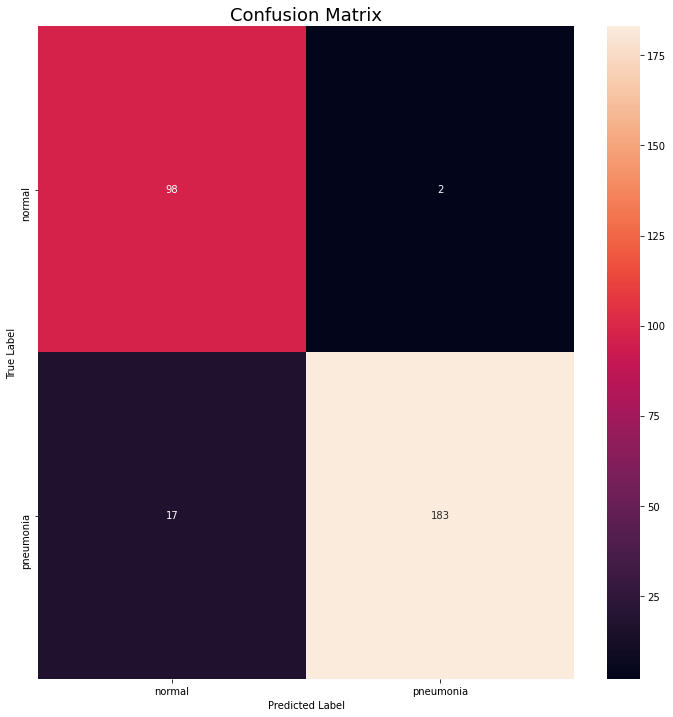

In [12]:
zeros = np.zeros(100, dtype=int)
ones = np.ones(200, dtype=int)
#Create numpy array of correct labels (since test images weren't shuffled we can build this list manually as order was preserved)
labels = np.concatenate((zeros, ones))

#Make predictions on test set
predictions = model.predict(test_ds)

#Create/plot confusion matrix comparing true and predicted values 
cm = confusion_matrix(y_pred=np.argmax(predictions, axis=-1), y_true=labels)
plt.figure(figsize=(12,12))
plt.title('Confusion Matrix', fontsize=18)
cmv = sns.heatmap(cm, annot=True, fmt='g', xticklabels=train_ds.class_names, yticklabels = train_ds.class_names)
cmv.set(xlabel = 'Predicted Label', ylabel='True Label')

#Print accuracy metrics based on confusion matrix 
normal_acc = (cm[0][0] / 100) * 100
pneu_acc = (cm[1][1] / 200) * 100
average_acc = ((normal_acc + pneu_acc) / 2)
print('Predicted Accuracy of Normal X-Rays: ', normal_acc, '%')
print('Predicted Accuracy of Pneumonia X-Rays: ', pneu_acc, '%')
print('Average Predicted Accuracy: ', average_acc, '%')

## References 

$1$ Freepik, Poster design for pneumonia with human lungs, Accessed 2021-03-28, Online: https://www.freepik.com/free-vector/poster-design-pneumonia-with-human-lungs_7541516.htm  
$2$ Mayoclinic, Pneumonia, Accessed 2021-03-28, Online: https://www.mayoclinic.org/diseases-conditions/pneumonia/symptoms-causes/syc-20354204?utm_source=Google&utm_medium=abstract&utm_content=Pneumonia&utm_campaign=Knowledge-panel    
$3$ Mendeley Data, Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification, Daniel Kermany, Kang Zhang, Michael Goldbaum, Accessed 2021-03-28, Online: https://data.mendeley.com/datasets/rscbjbr9sj/2   
$4$ TensorFlow, Image classification, Accessed 2021-03-05, Online: https://www.tensorflow.org/tutorials/images/classification#visualize_training_images    